# ARIMA Forecasting

Autoregressive Integrated Moving Average Model

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Any "non-seasonal" time series that contains patterns over time can be modeled with ARIMA by utilising its own lagged values and lagged forecast errors in order to forecast future values.

Load in the required libraries and python modules

In [1]:
\l ml/ml.q
\l ml/init.q
\l ../utils.q
arima:.p.import[`statsmodels.tsa.arima_model]`:ARIMA
plt:.p.import[`matplotlib.pyplot]

No shared object files for cutils.q, only q implementations available


## Daily Temp

### Data Preparation

The below dataset contains the mimimum daily temperatures reached in Melbourne during the period from January 1981 - Decemeber 1990.

Null values are removed from the dataset

In [2]:
show mintemp:`date`temp xcol ("PF";enlist",")0:`:../data/dailytemp.csv

// Delete any nulls from the data
mintemp:delete from mintemp where temp=0N

date                          temp
----------------------------------
1981.01.01D00:00:00.000000000 20.7
1981.01.02D00:00:00.000000000 17.9
1981.01.03D00:00:00.000000000 18.8
1981.01.04D00:00:00.000000000 14.6
1981.01.05D00:00:00.000000000 15.8
1981.01.06D00:00:00.000000000 15.8
1981.01.07D00:00:00.000000000 15.8
1981.01.08D00:00:00.000000000 17.4
1981.01.09D00:00:00.000000000 21.8
1981.01.10D00:00:00.000000000 20  
1981.01.11D00:00:00.000000000 16.2
1981.01.12D00:00:00.000000000 13.3
1981.01.13D00:00:00.000000000 16.7
1981.01.14D00:00:00.000000000 21.5
1981.01.15D00:00:00.000000000 25  
1981.01.16D00:00:00.000000000 20.7
1981.01.17D00:00:00.000000000 20.6
1981.01.18D00:00:00.000000000 24.8
1981.01.19D00:00:00.000000000 17.7
1981.01.20D00:00:00.000000000 15.5
..


Arima does not account for missing timestamps, these values must be added and then back/forward filled in order for the model to pick up on the trends in the dataset

In [3]:
mintemp:datefill[`date;mintemp;1D]

// Back and forward fill the missing data
mintemp:.ml.filltab[mintemp;();`date;::]

The data is plotted below to portray the trends and cycles present in the dataset

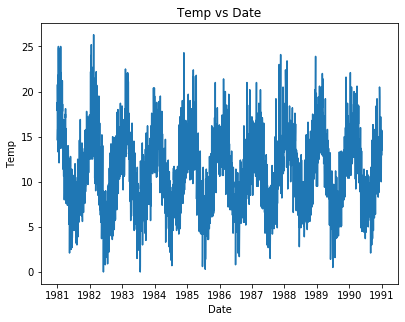

In [4]:
plttm[mintemp`date;mintemp`temp;"Temp"]

The data is then split into  a training and testing set (Making sure that no time leakage occurs). 

80% is chosen as train, 20% is testing data.

In [5]:
// Find the timestamp which splits the data 80/20
tts:ttstm[0.2;mintemp]

traintemp:tts`train
testtemp:tts`test

-1!"There is ",string[count traintemp]," datapoints in the training set"
-1!"There is ",string[count testtemp]," datapoints in the testing set"

"There is 2921 datapoints in the training set"


"There is 731 datapoints in the testing set"


### Training the model

The model can take the predicted values along with any other exogenous variables from the dataset that will aid in the forecasting of future datetimes

The variables that can be changed within the models include:

Parameter      |  Explanation
---------------|---------------------------
endog          | The endogenous variable ( The predicted y value)
order (p,d,q)  | Num of lag observations in the model, number of times that the observations are differenced, size of moving average window
exog (optional)          | exogenous variables
dates (optional)         | DateIndex associated with exog/ endog 
freq  (optional)         | Frequency of time series (‘B’, ‘D’, ‘W’, ‘M’, ‘A’, or ‘Q)

In [6]:
// The dates are converted to a pandas Dateindex to be passed to the model
stamplist:traintemp`date
dts:.p.import[`pandas;`:DatetimeIndex]["j"$stamplist-1970.01.01D0]

In the below model, the predicted values along with the associated dates are passed to initialise the model. The `order` variable, defines the q,d and q values for the model is set.

The model is then fit and summary value of the model printed

In [7]:
// Initialise the model, defining the p,d and q values
modeltemp:arima[`endog pykw traintemp`temp;`dates pykw dts;`order pykw (5 0 9);`freq pykw "D"]

// Fit the model, display is set to 0 to enable print statement from training
\ts mdlfittemp:modeltemp[`:fit][`disp pykw 0];

// Print the model summary
mdlfittemp[`:summary][];

/Users/dianeodonoghue/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/dianeodonoghue/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/dianeodonoghue/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/dianeodonoghue/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/dianeodonoghue/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


78414 4196352


/Users/dianeodonoghue/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/Users/dianeodonoghue/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/dianeodonoghue/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/dianeodonoghue/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


### Model Forecasting

The future values are forecasted using the `forecast` feature of the fitted model. 

This returns an array with tree values:

- The forecasted values
- The standard error associated with each forecasted value
- A 2 dimensional array of the confidence interval of each forecast

The forecasted values are used to calculated the associated error

In [8]:
// Future forecasts are made
predstemp:mdlfittemp[`:forecast][`steps pykw count testtemp]`

// Calculate the error
-1!"The Mean squared error is ",string .ml.mse[predstemp[0];testtemp[`temp]]

"The Mean squared error is 8.024815"


The predicted and real values are also plotted to show how the models forecasted values varied from the true values

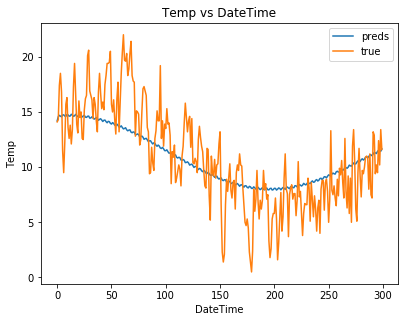

In [9]:
pltresult[300#predstemp[0];300#testtemp`temp;"Temp"]

The above forecast, captures the overall shape of the future values, however fails to predict the cyclical features present at the smaller time intervals

## Bike Rental

### Data Preparation

**In this section a more complex model is used with exogenous variables included in the training of the models**

Load in the data

The dataset is a provided by TFL to predict future bike sales per hour. Additional data is also given in the form of seasonality and climate information such as season, indication of whether it is a holiday, temperature, wind_speed, current weather etc .

For the purpose of these notebook, when predictions are being made, it is assumed that these climate information will be available based off future weather predictions. 

In [10]:
show bikes:("PFFFFFFBFF";enlist ",")0:`:../data/london_merged.csv

timestamp                     cnt  t1  t2   hum  wind_speed weather_code is_h..
-----------------------------------------------------------------------------..
2015.01.04D00:00:00.000000000 182  3   2    93   6          3            0   ..
2015.01.04D01:00:00.000000000 138  3   2.5  93   5          1            0   ..
2015.01.04D02:00:00.000000000 134  2.5 2.5  96.5 0          1            0   ..
2015.01.04D03:00:00.000000000 72   2   2    100  0          1            0   ..
2015.01.04D04:00:00.000000000 47   2   0    93   6.5        1            0   ..
2015.01.04D05:00:00.000000000 46   2   2    93   4          1            0   ..
2015.01.04D06:00:00.000000000 51   1   -1   100  7          4            0   ..
2015.01.04D07:00:00.000000000 75   1   -1   100  7          4            0   ..
2015.01.04D08:00:00.000000000 131  1.5 -1   96.5 8          4            0   ..
2015.01.04D09:00:00.000000000 301  2   -0.5 100  9          3            0   ..
2015.01.04D10:00:00.000000000 528  3   -

The trends over time for the data is plotted below which shows that cyclical patterns are present in the dataset

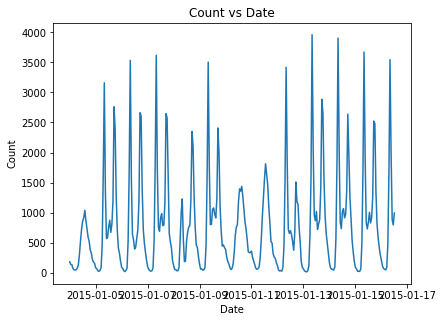

In [11]:
plttm[300#bikes`timestamp;300#bikes`cnt;"Count"]

Arima does not account for missing timestamps, these values must be added and then back/forward filled in order for the model to pick up on the trends in the dataset

In [12]:
// Include any missing datetimes
bikes:datefill[`timestamp;bikes;01:00:00.000]

// Back and forward fill the missing data
bikes:.ml.dropconstant[.ml.filltab[bikes;();`timestamp;::]]

The data is then split into  a training and testing set (Making sure that no time leakage occurs). 

80% is chosen as train, 20% is testing data.

In [13]:
// Find the timestamp which splits the data 80/20
tts:ttstm[0.2;bikes]

trainbk:tts`train
testbk:tts`test

-1!"There is ",string[count trainbk]," datapoints in the training set"
-1!"There is ",string[count testbk]," datapoints in the testing set"

"There is 14035 datapoints in the training set"


"There is 3509 datapoints in the testing set"


### Training the model

The datetimes and exogenous columns are defined

In [14]:
// The dates are converted to a pandas Dateindex to be passed to the model
stamplist:trainbk`timestamp
dts:.p.import[`pandas;`:DatetimeIndex]["j"$stamplist-1970.01.01D0]

// Define exogenous cols
exogcol:`t1`t2`hum`wind_speed`weather_code`is_weekend`season

The model is initialised, with the exogenous variables included in the fitting of the model along with the associated datetimes. The p,q and d values are also defined.

In [15]:
// Initialise model, including additional columns in the dataset
\ts modelbk:arima[trainbk`cnt;`order pykw (0 0 1);`dates pykw dts;
    `exog pykw flip trainbk[exogcol]]

// Fit the model, display is set to 0 to enable print statement from training
\ts mdlfitbk:modelbk[`:fit][`disp pykw 0]

// Print the model summary
mdlfitbk[`:summary][];

/Users/dianeodonoghue/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


27 6124656


9660 1952


### Model Forecasting

The future values are forecasted using the `forecast` feature of the fitted model. The additional column are also included in the forecast to aid with predictions. 

The forecasted values are used to calculated the associated error

In [16]:
// Forecast future values, including the additional columns
predsbk:mdlfitbk[`:forecast][`steps pykw count testbk;`exog pykw 
       flip testbk[exogcol]]`

// Calculate the error using the first value from the preds list
-1!"The Root Mean Squared Log Error is ",string .ml.rmsle[predsbk[0];testbk[`cnt]]

"The Root Mean Squared Log Error is 1.182413"


The predicted and real values are also plotted to show how the models forecasted values varied from the true values

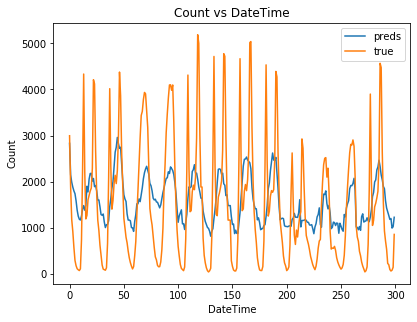

In [17]:
pltresult[300#predsbk[0];300#testbk`cnt;"Count"]

Similar to the prior dataset, the overall shape of the trend is captured by the model, except in this scenario the peaks and troughs fail to predict the full range of the cyclical patterns